# Fit to epidemiological models

## March 2020

In [70]:
import os
import sys
import glob
import time
import warnings
import datetime 
print("Last updated on ", time.asctime())

Last updated on  Sat Mar 28 20:28:42 2020


In [71]:
import numpy as np
import pandas as pd
import matplotlib

In [72]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [73]:
## mathplotlib configuration
fontsize = 12
plt.rcParams["figure.figsize"] = 6, 5
plt.rcParams["font.size"     ] = fontsize

#font = {'family': 'serif',
#        'color':  'black',
#        'weight': 'bold',
#        'size': fontsize,
#        }

plt.style.context('seaborn-colorblind');


In [361]:
import scipy.stats  as stats
from  scipy.optimize import curve_fit
from  scipy.optimize import minimize
from scipy.integrate import odeint
import scipy.integrate as spi
from scipy.interpolate import interp1d

from dataclasses import dataclass, field

In [136]:
from   c19.types import SIR
import c19.basic_models as cbm
import c19.basic_models as sir_deriv

import c19.plotting as cplt
import c19.core_functions as cf
import c19.fit_functions_ic as ff

In [76]:
import c19.cfit         as cfit
import c19.myhistograms as mhst

# The SIR model

- A simple mathematical description of the spread of a disease in a population is the so-called SIR model, which divides the (fixed) population of N individuals into three "compartments" which may vary as a function of time, t:

- $S(t)$ are those susceptible but not yet infected with the disease;
- $I(t)$ is the number of infectious individuals;
- $R(t)$ are those individuals who have recovered from the disease and now have immunity to it.

The SIR model describes the change in the population of each of these compartments in terms of two parameters, $\beta$ and $\gamma$. 
β describes the effective contact rate of the disease: an infected individual comes into contact with βN other individuals per unit time (of which the fraction that are susceptible to contracting the disease is S/N). γ is the mean recovery rate: that is, 1/γ
is the mean period of time during which an infected individual can pass it on.

The differential equations describing this model were first derived by Kermack and McKendrick [Proc. R. Soc. A, 115, 772 (1927)]:

$$
\frac{dS}{dt} = - \frac{\beta S I}{N} \\
\frac{dI}{dt} = \frac{\beta S I}{N} - \gamma I \\
\frac{dR}{dt} = \gamma R
$$

## Example

1. Define the SIR parameters.The model is initialised with the size of the population (N) and the initial values of the population. Here we choose I=1 (the epidemics starts with one infected case), R = 0 (no one has recovered yet), and S = N - I - R

2. The COVID parameters are: R0 =3, T = 7 days (T is the recovery/infection time). The parameters that enter the differential equations are gamma = 1/T and beta = R0 * gamma.

3. The system is solved for a time grid. 

In [318]:
# Total population, N.
N = 1000
# Initial number of infected and recovered individuals, I0 and R0.
i0, r0 = 1, 0
y0 = cbm.set_sir_initial_conditions(N, i0, r0)

# Contact rate, beta, and mean recovery rate, gamma, (in 1/days).
R0 = 3.
gamma = 1./7.   # inverse of infection time
beta = R0 * gamma
# A grid of time points (in days)
t = np.linspace(0, 100, 200)

In [319]:
N0, beta0, gamma0 = N, beta, gamma

In [320]:
# Integrate the SIR equations over the time grid, t.
ret = odeint(cbm.sir_deriv, y0, t, args=(N, beta, gamma))
S, I, R = ret.T

In [321]:
sir_example = SIR(N, S, I, R, t, R0, beta, gamma)

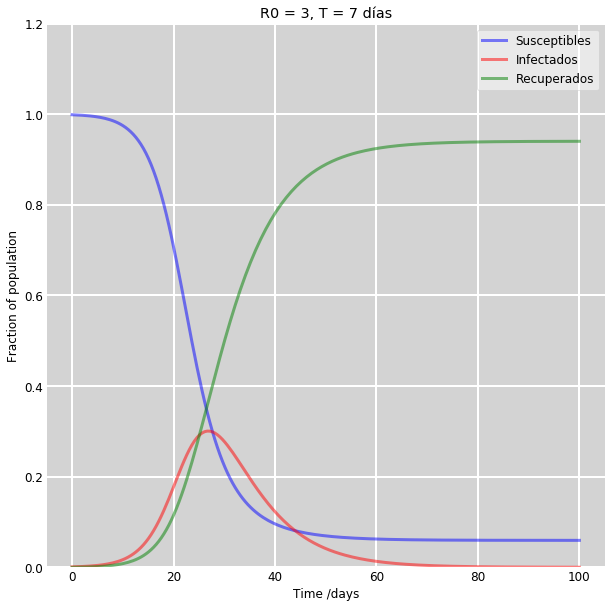

In [322]:
cplt.plot_sir(sir_example, "R0 = 3, T = 7 días")

### Draft code for fitting

In [323]:
def shift_to_bin_centers(x):
    """
    Return bin centers, given bin lower edges.
    """
    return x[:-1] + np.diff(x) * 0.5

def bin_edges(ts, nbins=400):
    return np.linspace(ts[0], ts[-1], nbins + 1)

def bins(ts, nbins=400):
    return shift_to_bin_centers(bin_edges(ts, nbins))



In [324]:
def binedges(ts):
    dt = 0.5*(ts[-1] - ts[-2])
    tbins = np.array([t[i] - 0.5*(t[i+1] - t[i]) for i in range(len(ts)-1)] + [ts[-1] - dt, ts[-1] +dt])
    #print(len(tbins))
    return tbins

In [325]:
tbins = binedges(sir_example.t)

In [326]:
len(tbins)

201

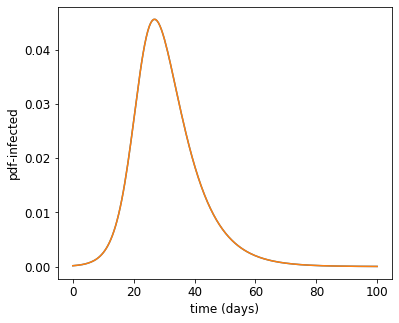

In [327]:
rv_infected = stats.rv_histogram((sir_example.I/sir_example.N, tbins)) 
plt.plot(sir_example.t, rv_infected.pdf(sir_example.t));
plt.plot(sir_example.t, (np.sum(rv_infected.pdf(sir_example.t))/np.sum(sir_example.I/sir_example.N))*sir_example.I/sir_example.N);
plt.xlabel('time (days)'); plt.ylabel('pdf-infected');

In [328]:
np.sum(sir_example.I/sir_example.N)

13.100386743710006

In [329]:
np.sum(rv_infected.pdf(sir_example.t))

1.9900000000000002

In [330]:
def sir_i_generator(rvi, size = 100000, bins=100):

    xis = rvi.rvs(size = size)
    i, tt = np.histogram(xis, bins=100)
    return shift_to_bin_centers(tt), i

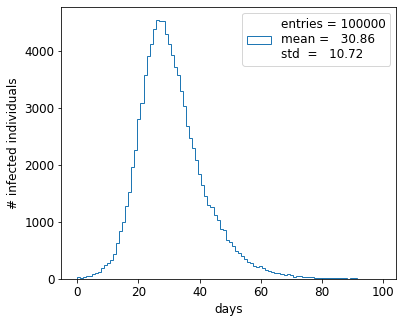

In [331]:
xis = rv_infected.rvs(size = 100000);
mhst.hist(xis, 100); plt.xlabel('days'); plt.ylabel('# infected individuals');

In [332]:
t, i= sir_i_generator(rv_infected, size = 100000, bins=100)
err = 0.05
ierr = err * i + 1

In [333]:
ierr

array([  2.25,   1.9 ,   2.5 ,   2.75,   3.85,   3.65,   5.45,   5.85,
         7.1 ,  12.2 ,  13.3 ,  18.2 ,  23.55,  29.4 ,  35.85,  45.8 ,
        57.1 ,  75.4 ,  90.9 , 108.75, 130.5 , 144.4 , 163.95, 188.25,
       197.6 , 220.15, 219.  , 224.35, 219.65, 224.9 , 206.7 , 203.  ,
       195.35, 180.5 , 165.55, 149.6 , 140.  , 126.6 , 119.65, 108.35,
        98.65,  89.75,  81.9 ,  75.5 ,  65.35,  58.15,  56.6 ,  50.2 ,
        42.95,  42.8 ,  32.75,  33.75,  27.35,  25.05,  21.8 ,  21.15,
        16.45,  15.95,  14.45,  13.  ,  11.9 ,  11.1 ,  10.9 ,   8.45,
         7.5 ,   7.2 ,   6.05,   6.25,   5.7 ,   5.25,   4.8 ,   4.05,
         4.15,   3.45,   3.2 ,   3.3 ,   2.45,   2.85,   2.35,   2.65,
         2.05,   1.65,   1.9 ,   2.05,   1.65,   1.8 ,   1.4 ,   1.35,
         1.65,   1.4 ,   1.2 ,   1.4 ,   1.3 ,   1.3 ,   1.2 ,   1.1 ,
         1.25,   1.25,   1.05,   1.15])

In [351]:
def cumulative_sum_and_error(i, ierr):
    CI = np.cumsum(i)
    i2 = np.square(ierr)
    ci2 = np.cumsum(i2)
    CIe = np.sqrt(ci2)
    return CI, CIe
    

In [352]:
ic, ice = cumulative_sum_and_error(i, ierr)

In [353]:
def plt_sir_data(t, i, ierr, ic, ice, log=False, figsize=(12,12), ms=7): 
    fig = plt.figure(figsize=figsize)
    if log:
        plt.yscale('log')
    
    ax      = fig.add_subplot(2, 1, 1)
    
    
    plt.errorbar(t, i, fmt="kp", yerr= ierr, ms=ms, ls='none')
    plt.xlabel('Date in days')
    plt.ylabel('Number of cases')
    plt.grid()

    ax      = fig.add_subplot(2, 1, 2)
    plt.errorbar(t, ic, fmt="kp", yerr= ice, ms=ms, ls='none')
    plt.xlabel('Date in days')
    plt.ylabel('Cumulative Number of cases')
    plt.grid()

    plt.tight_layout()
    

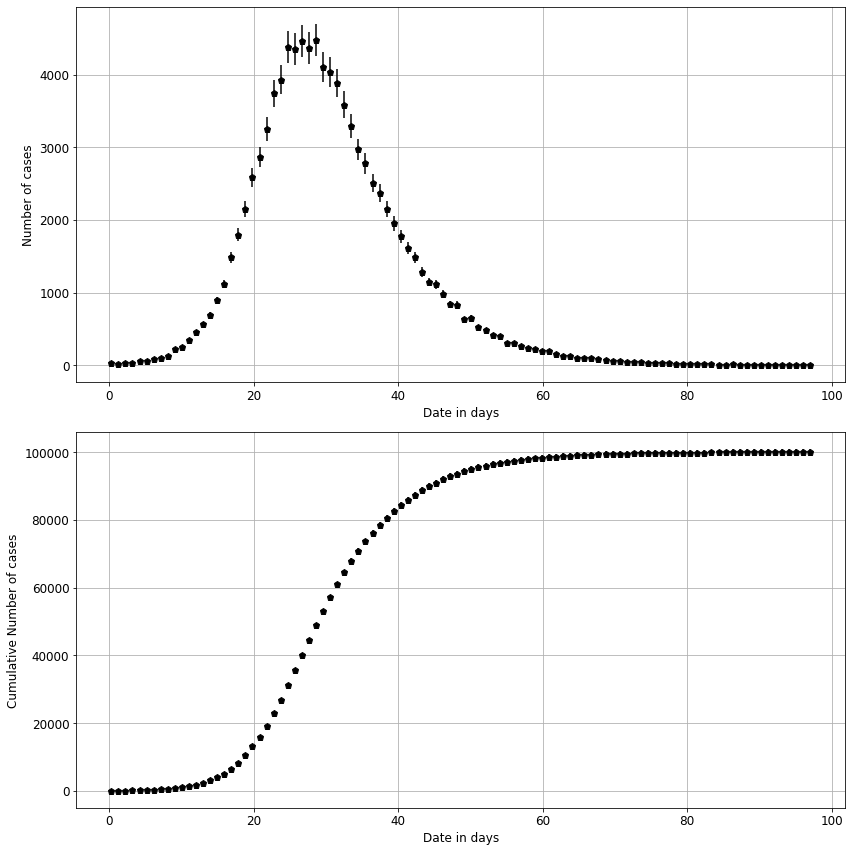

In [355]:
plt_sir_data(t, i, ierr, ic, ice, log=False, figsize=(12,12), ms=7)

In [387]:
def t_select(t, i, ic, ierr, tmax=20):
    return t[t<tmax], i[t<tmax], ic[t<tmax], ierr[t<tmax] 

In [389]:
tt, it, ict, ierrt = t_select(t, i, ic, ierr, tmax=20)

In [379]:
tt

array([ 0.2535553 ,  1.23130024,  2.20904519,  3.18679013,  4.16453507,
        5.14228002,  6.12002496,  7.09776991,  8.07551485,  9.0532598 ,
       10.03100474, 11.00874969, 11.98649463, 12.96423958, 13.94198452,
       14.91972947, 15.89747441, 16.87521935, 17.8529643 , 18.83070924,
       19.80845419])

In [380]:
it

array([  25,   18,   30,   35,   57,   53,   89,   97,  122,  224,  246,
        344,  451,  568,  697,  896, 1122, 1488, 1798, 2155, 2590])

In [381]:
ict

array([   25,    43,    73,   108,   165,   218,   307,   404,   526,
         750,   996,  1340,  1791,  2359,  3056,  3952,  5074,  6562,
        8360, 10515, 13105])

In [ ]:
[logL(x, ict) for x in rc]

In [440]:
def logL(r, ic):
    l1 = -r * np.sum(ic)
    l2 = (ic[-1] - ic[0]) * np.log(1 - np.exp(-r))
    return -ic[0] * (l1 + l2)

In [441]:
rc = np.arange(0.05, 0.5, 0.01)
yc = [logL(x, ict) for x in rc]

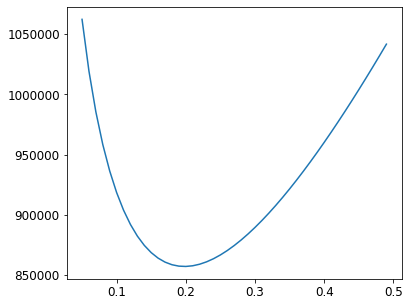

In [442]:
plt.plot(rc, yc)

In [ ]:
def mle(x, llike, r):
    """ compute maximum likelihood estimate
    parameters:
        x    : np.array      ,   C(i)
        llike: callable      ,   logL
        r    : r parameter
    """
    def mll(r):
        return logL(r, x)
    result = optimize.minimize(_mll, ps, method='Nelder-Mead')
    if (not result.success): print('mle: warning')
    #print('mle ', result)
    return result.x

In [403]:
ict

array([   25,    43,    73,   108,   165,   218,   307,   404,   526,
         750,   996,  1340,  1791,  2359,  3056,  3952,  5074,  6562,
        8360, 10515, 13105])

In [439]:
ict[0]

25

In [443]:
result = minimize(logL, (0.1), args=(ict))

In [444]:
result

      fun: 857070.2250947137
 hess_inv: array([[1.20288808e-07]])
      jac: array([0.])
  message: 'Optimization terminated successfully.'
     nfev: 30
      nit: 8
     njev: 10
   status: 0
  success: True
        x: array([0.1980219])

In [446]:
result.x[0]

0.19802190085584448

In [386]:
i[0]

25

In [391]:
def plt_fit_data(t, i, ierr, r, log=False, figsize=(12,12), ms=7): 
    
    def c(t):
        return i[0]*np.exp(r* t)
    
    fig = plt.figure(figsize=figsize)
    if log:
        plt.yscale('log')
    
    ax      = fig.add_subplot(1, 1, 1)
    
    
    plt.errorbar(t, i, fmt="kp", yerr= ierr, ms=ms, ls='none')
    plt.plot(t, c(t))
    plt.xlabel('Date in days')
    plt.ylabel('Number of cases')
    plt.grid()


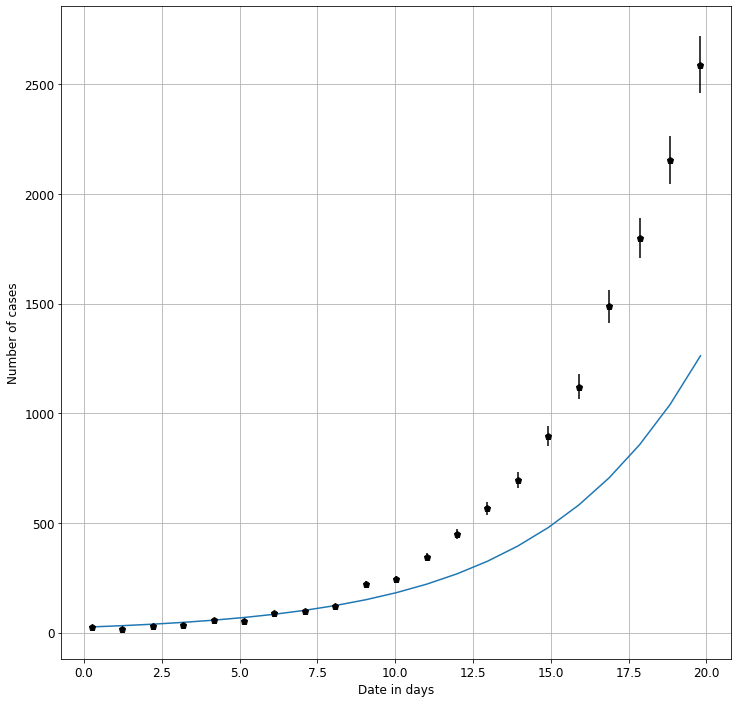

In [445]:
plt_fit_data(tt, it, ierrt, r=0.198, log=False, figsize=(12,12), ms=7)

In [ ]:
def cum_sum(df, data):
        Y = np.flip(df[data].values)
        CY = np.cumsum(Y)
        FCY = np.flip(CY)
        return FCY

In [336]:
def fit_exponential_rise(t,i,ierr,trange=(15,30), seed=(10, 0.5), log=False, figsize=(12,12), ms=7):
    def exponential(x, const, slope):
        return const * np.exp(slope * x)

    sel  = cf.in_range(t, *trange)
    tt, ii, iierr = t[sel], i[sel], ierr[sel]
    
    F = ff.fit(exponential, tt, ii, seed = seed, sigma=iierr)
    R0 = 1+ F.values[1] / gamma
    
    fig = plt.figure(figsize=figsize)
    if log:
        plt.yscale('log')

    plt.errorbar(t, i, fmt="kp", yerr= ierr, ms=ms, ls='none')
    plt.plot(tt,F.fn(tt))
    plt.xlabel('Date in days')
    plt.ylabel('Number of cases')
    plt.grid()

    return F, R0

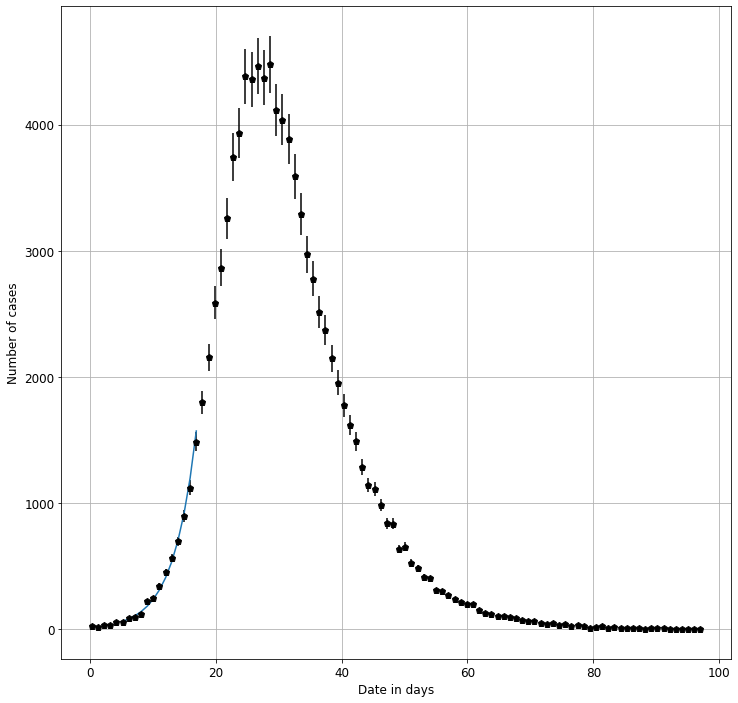

In [453]:
F, R0 = fit_exponential_rise(t,i,ierr,trange=(5,17), seed=(10, 0.5), log=False, figsize=(12,12), ms=7)

In [ ]:
print(f'chi2 = {F.chi2}, N = {F.values[0]}, slope={F.values[1]} R0 = {R0}')

In [234]:
F, R0 = fit_exponential_rise(t,i,ierr,trange=(15,30), seed=(10, 0.5))

In [235]:
def plt_fit_data(t,i,ierr, F, R0, trange=(15,30), log=False, figsize=(12,12), ms=7): 
    fig = plt.figure(figsize=figsize)
    if log:
        plt.yscale('log')

    plt.errorbar(t, i, fmt="kp", yerr= ierr, ms=ms, ls='none')
    sel  = cf.in_range(t, *trange)
    tt, ii, iierr = t[sel], i[sel], ierr[sel]
    plt.plot(tt,F.fn(tt))
    plt.xlabel('Date in days')
    plt.ylabel('Number of cases')
    plt.grid()


ValueError: x and y must have same first dimension, but have shapes (20,) and (100,)

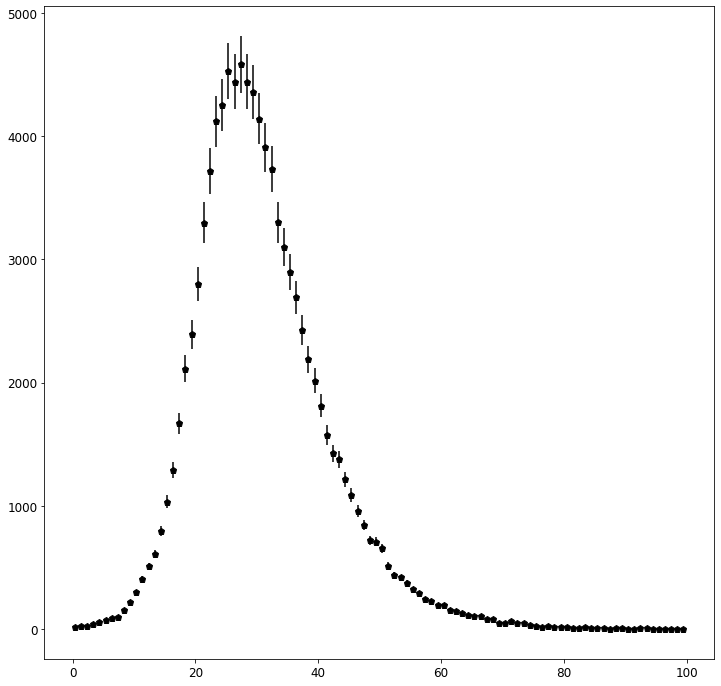

In [312]:
plt_fit_data(t,i,ierr, F, R0, trange=(15,35), log=False, figsize=(12,12), ms=7)

In [139]:
err = 0.05
ierr = err * i

In [174]:
def sir_calib(t):
    N = 1e+5
    R0 = 3.
    gamma = 1./7.   # inverse of infection time
    beta = R0 * gamma
    y0 = cbm.set_sir_initial_conditions(N, 1, 0)
    ret = odeint(cbm.sir_deriv, y0, t, args=(N, beta, gamma))
    S, I, R = ret.T
    return I

In [264]:
def sir_fitf(x, beta):
    N = 1
    T = 7
    gamma = 1/T
    y0 = cbm.set_sir_initial_conditions(N, 1, 0)
    ret = odeint(cbm.sir_deriv, y0, t, args=(N, beta, gamma))
    S, I, R = ret.T
    return I

In [266]:
t

array([ 0.85824152,  1.854371  ,  2.85050047,  3.84662995,  4.84275943,
        5.8388889 ,  6.83501838,  7.83114786,  8.82727733,  9.82340681,
       10.81953629, 11.81566576, 12.81179524, 13.80792472, 14.80405419,
       15.80018367, 16.79631315, 17.79244262, 18.7885721 , 19.78470158,
       20.78083105, 21.77696053, 22.77309001, 23.76921948, 24.76534896,
       25.76147844, 26.75760791, 27.75373739, 28.74986687, 29.74599634,
       30.74212582, 31.7382553 , 32.73438478, 33.73051425, 34.72664373,
       35.72277321, 36.71890268, 37.71503216, 38.71116164, 39.70729111,
       40.70342059, 41.69955007, 42.69567954, 43.69180902, 44.6879385 ,
       45.68406797, 46.68019745, 47.67632693, 48.6724564 , 49.66858588,
       50.66471536, 51.66084483, 52.65697431, 53.65310379, 54.64923326,
       55.64536274, 56.64149222, 57.63762169, 58.63375117, 59.62988065,
       60.62601012, 61.6221396 , 62.61826908, 63.61439855, 64.61052803,
       65.60665751, 66.60278698, 67.59891646, 68.59504594, 69.59

In [267]:
i

array([   3,    2,    0,    1,    6,    2,    7,    3,    9,   11,   17,
         21,   29,   47,   69,   61,   98,  123,  176,  194,  264,  343,
        473,  571,  806,  991, 1297, 1564, 1928, 2383, 2779, 3211, 3536,
       3964, 4297, 4401, 4452, 4627, 4541, 4327, 4200, 3890, 3702, 3361,
       3131, 2945, 2747, 2412, 2236, 2069, 1867, 1704, 1476, 1318, 1189,
       1058,  991,  859,  849,  684,  639,  513,  481,  425,  395,  344,
        344,  298,  217,  252,  193,  174,  168,  148,  122,  115,  118,
         88,   87,   78,   56,   39,   46,   41,   34,   45,   25,   42,
         24,   18,   26,   14,   14,    9,    7,   11,   11,    4,    7,
          6])

In [268]:
ierr

array([  1.15,   1.1 ,   1.  ,   1.05,   1.3 ,   1.1 ,   1.35,   1.15,
         1.45,   1.55,   1.85,   2.05,   2.45,   3.35,   4.45,   4.05,
         5.9 ,   7.15,   9.8 ,  10.7 ,  14.2 ,  18.15,  24.65,  29.55,
        41.3 ,  50.55,  65.85,  79.2 ,  97.4 , 120.15, 139.95, 161.55,
       177.8 , 199.2 , 215.85, 221.05, 223.6 , 232.35, 228.05, 217.35,
       211.  , 195.5 , 186.1 , 169.05, 157.55, 148.25, 138.35, 121.6 ,
       112.8 , 104.45,  94.35,  86.2 ,  74.8 ,  66.9 ,  60.45,  53.9 ,
        50.55,  43.95,  43.45,  35.2 ,  32.95,  26.65,  25.05,  22.25,
        20.75,  18.2 ,  18.2 ,  15.9 ,  11.85,  13.6 ,  10.65,   9.7 ,
         9.4 ,   8.4 ,   7.1 ,   6.75,   6.9 ,   5.4 ,   5.35,   4.9 ,
         3.8 ,   2.95,   3.3 ,   3.05,   2.7 ,   3.25,   2.25,   3.1 ,
         2.2 ,   1.9 ,   2.3 ,   1.7 ,   1.7 ,   1.45,   1.35,   1.55,
         1.55,   1.2 ,   1.35,   1.3 ])

In [269]:
sir_example.t

array([  0.        ,   0.50251256,   1.00502513,   1.50753769,
         2.01005025,   2.51256281,   3.01507538,   3.51758794,
         4.0201005 ,   4.52261307,   5.02512563,   5.52763819,
         6.03015075,   6.53266332,   7.03517588,   7.53768844,
         8.04020101,   8.54271357,   9.04522613,   9.54773869,
        10.05025126,  10.55276382,  11.05527638,  11.55778894,
        12.06030151,  12.56281407,  13.06532663,  13.5678392 ,
        14.07035176,  14.57286432,  15.07537688,  15.57788945,
        16.08040201,  16.58291457,  17.08542714,  17.5879397 ,
        18.09045226,  18.59296482,  19.09547739,  19.59798995,
        20.10050251,  20.60301508,  21.10552764,  21.6080402 ,
        22.11055276,  22.61306533,  23.11557789,  23.61809045,
        24.12060302,  24.62311558,  25.12562814,  25.6281407 ,
        26.13065327,  26.63316583,  27.13567839,  27.63819095,
        28.14070352,  28.64321608,  29.14572864,  29.64824121,
        30.15075377,  30.65326633,  31.15577889,  31.65

In [271]:
sir_example.I

array([1.00000000e+00, 1.15437956e+00, 1.33258863e+00, 1.53830419e+00,
       1.77577034e+00, 2.04988542e+00, 2.36630271e+00, 2.73154669e+00,
       3.15314687e+00, 3.63979221e+00, 4.20150912e+00, 4.84986661e+00,
       5.59821258e+00, 6.46194608e+00, 7.45883084e+00, 8.60935598e+00,
       9.93715108e+00, 1.14694635e+01, 1.32377066e+01, 1.52780897e+01,
       1.76323406e+01, 2.03485332e+01, 2.34820363e+01, 2.70965970e+01,
       3.12655784e+01, 3.60733698e+01, 4.16169898e+01, 4.80079056e+01,
       5.53740894e+01, 6.38623362e+01, 7.36408661e+01, 8.49022291e+01,
       9.78665307e+01, 1.12784986e+02, 1.29943803e+02, 1.49668378e+02,
       1.72327764e+02, 1.98339343e+02, 2.28173607e+02, 2.62358866e+02,
       3.01485678e+02, 3.46210677e+02, 3.97259393e+02, 4.55427522e+02,
       5.21579972e+02, 5.96646853e+02, 6.81615423e+02, 7.77516857e+02,
       8.85406594e+02, 1.00633700e+03, 1.14132119e+03, 1.29128702e+03,
       1.45702104e+03, 1.63910262e+03, 1.83783004e+03, 2.05314136e+03,
      

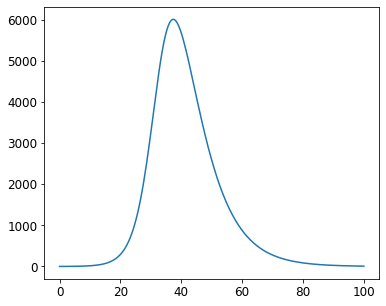

In [272]:
plt.plot(sir_example.t, sir_example.I)

In [265]:
popt, pcov = curve_fit(sir_fitf, t, i, p0=(0.3), sigma=ierr)

/Users/jjgomezcadenas/miniconda/envs/IC-3.7-2018-11-14/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [256]:
popt

array([0.3])

In [257]:
pcov

array([[inf]])

In [258]:
F = ff.fit(sir_fitf, t, i, seed=(0.3), sigma=ierr)

In [259]:
F

FitFunction(fn=<function fit.<locals>.<lambda> at 0x1a2213a830>, values=array([0.3]), errors=array([inf]), chi2=267.9591070218579, pvalue=0.0, cov=array([[inf]]))

In [260]:
beta

0.42857142857142855

In [261]:
gamma

0.14285714285714285

In [262]:
def plt_sir_data_fit(t,i, ierr, F, figsize=(12,12), ms=7, linewidth=2): 
    fig = plt.figure(figsize=figsize)
    plt.errorbar(t, i, fmt="kp", yerr= ierr, ms=ms, ls='none')
    plt.plot(t, F(t), linewidth=linewidth)
    plt.xlabel('Date in days')
    plt.ylabel('Number of cases')
    plt.grid()


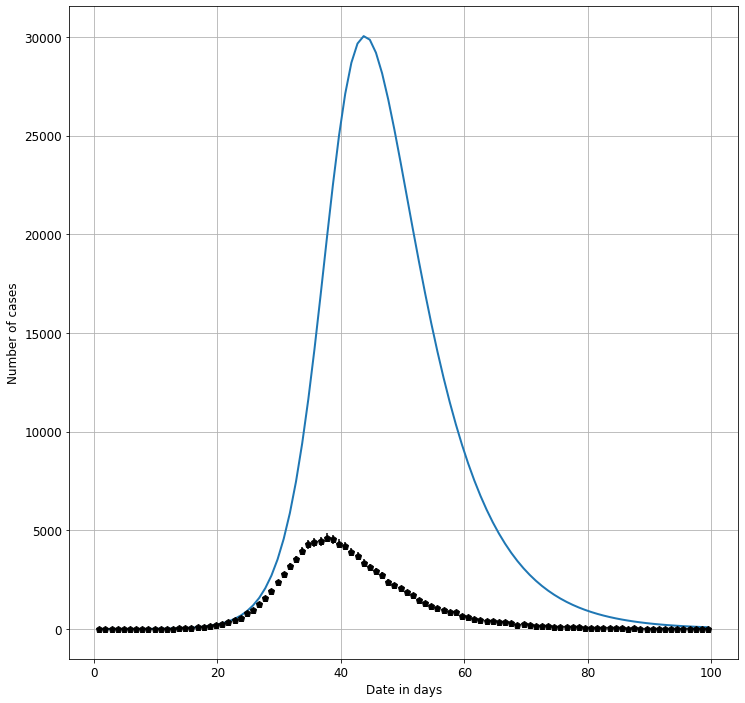

In [263]:
plt_sir_data_fit(t,i, ierr, sir_calib)

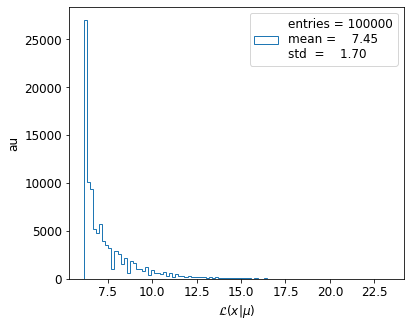

In [108]:
mhst.hist(lps, 100, xylabels = (r'$\mathcal{L}(x | \mu)$', 'au'));

In [109]:
def sir_constrains(N, beta, gamma, N0 = 10, beta0 = 1e-41, gamma0 = 1e-41):
    N     = np.max(N   , N0)
    beta  = np.max(beta, bet0)
    gamma = np.max(gamma, gamma0)
    return N, beta, gamma

def rv_sir_infected(N, beta, gamma):
    #N, beta, gamma = sir_constrains(N, beta, gamma)
    ret = odeint(cbm.sir_deriv, y0, t, args=(N, beta, gamma))
    S, I, R = ret.T
    sir = SIR(N, S, I, R, t, R0, beta, gamma)
    #sels = sir.t <= tc
    #print(sels)
    tbins  = binedges(sir.t)
    rv_ = stats.rv_histogram((sir.I, tbins)) 
    return rv_

def sir_llike(x, N, beta, gamma):
    rv = rv_sir_infected(N, beta, gamma)
    return rv.logpdf(x)

In [110]:
sir_pars = (N, beta, gamma)
rv = rv_sir_infected(*sir_pars)
xs = rv.rvs(size = 100000)

In [120]:
xs[0:10]

array([44.57980572, 35.96423943, 43.09932509, 42.09553564, 39.88903901,
       37.786152  , 37.41028452, 59.76411206, 43.92132105, 37.43523285])

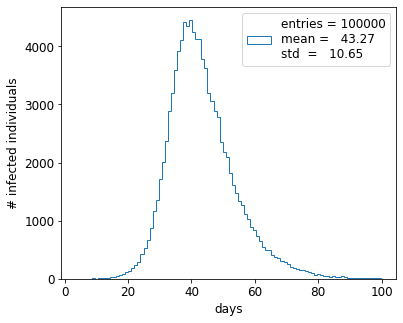

In [111]:
mhst.hist(xs, 100, xylabels=('days', '# infected individuals'));

In [112]:
t, i= sir_i_generator(rv_infected, size = 100000, bins=100)

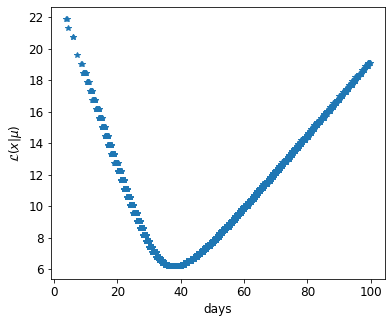

In [113]:
ll = -2*sir_llike(xs, *sir_pars)
plt.plot(xs , ll, marker = '*', ls = '');
plt.xlabel('days'); plt.ylabel(r'$\mathcal{L}(x | \mu)$');

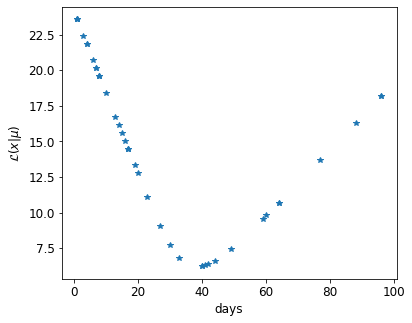

In [115]:
ll2 = -2*sir_llike(i, *sir_pars)
plt.plot(i , ll2, marker = '*', ls = '');
plt.xlabel('days'); plt.ylabel(r'$\mathcal{L}(x | \mu)$');

## Test one experiment

- Fixed parameters: $N, \gamma$.
- Free paramter   : $\beta$
- size            : 1000 infected individuals

In [118]:
def sir_experiment(N, beta, gamma, size = 10000, tc = 1e10):
    sir_pars     = (N  , beta, gamma)
    sir_parsmask = (False, True, False)
    xs = rv.rvs(size = size)
    xs = xs[xs < tc]
    parshat = cfit.parbest(xs, sir_llike, sir_pars, sir_parsmask)
    #print(parshat)
    #print(N, beta, gamma)
    return xs, parshat

In [119]:
xs, phat = sir_experiment(N, beta, gamma)
print('best parameters = ', *phat)
print('true parameters = ', N, beta, gamma)

best parameters =  20000.0 0.41686314174107136 0.14285714285714285
true parameters =  20000 0.42857142857142855 0.14285714285714285


In [130]:
def sir_experiment2(N, beta, gamma, size = 10000, bins = 100, tc = 1e10):
    sir_pars     = (N  , beta, gamma)
    sir_parsmask = (False, True, False)
    rv = rv_sir_infected(*sir_pars)
    t, i = sir_i_generator(rv, size, bins)
    print(t[t<tc])
    print(i[t<tc])
    parshat = cfit.parbest(i[t<tc], sir_llike, sir_pars, sir_parsmask)
    print(parshat)
    #print(N, beta, gamma)
    return parshat

In [135]:
pars = sir_experiment2(N, beta, gamma, size = 10000, bins = 10, tc = 30)
print('best parameters = ', *pars)
print('true parameters = ', N, beta, gamma)

[ 3.01158218  3.97998886  4.94839554  5.91680223  6.88520891  7.8536156
  8.82202228  9.79042897 10.75883565 11.72724234 12.69564902 13.66405571
 14.63246239 15.60086907 16.56927576 17.53768244 18.50608913 19.47449581
 20.4429025  21.41130918 22.37971587 23.34812255 24.31652924 25.28493592
 26.2533426  27.22174929 28.19015597 29.15856266]
[  1   1   0   0   0   0   1   0   2   5   1   5   4   4   9  17   7  14
  14  28  35  37  69  79  88 131 140 187]
mle: warning
[2.00000000e+04 4.28571429e-01 1.42857143e-01]
best parameters =  20000.0 0.42857142857142855 0.14285714285714285
true parameters =  20000 0.42857142857142855 0.14285714285714285


## Test nsample experiments

Test different experiments with samples at different collection times

In [24]:
def sir_experiments(N, beta, gamma, size = 10000 , nsample = 100, tc = 1e10):
    Ns, betas, gammas = np.zeros(nsample), np.zeros(nsample), np.zeros(nsample)
    for i in range(nsample):
        xs, parshat = sir_experiment(N, beta, gamma, size, tc)
        Ns[i], betas[i], gammas[i] = parshat[0], parshat[1], parshat[2]
    return Ns, betas, gammas

true beta 0.42857142857142855


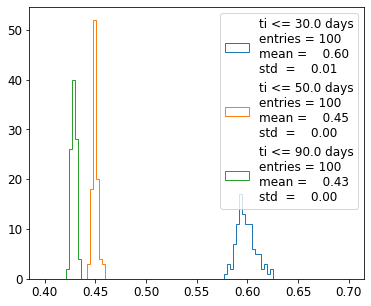

In [25]:
tcs = [30., 50., 90.] # collection times (days)
for ti in tcs:
    Ns, betas, gammas = sir_experiments(N, beta, gamma, size = 1000, nsample = 100, tc = ti)
    mhst.hist(betas, 100, range = (0.4, 0.7), label = 'ti <= '+str(ti)+' days')
print('true beta', beta)

There is a bias due to the incomplete events in the infected time distribution.

Before the 'peak', $\beta$ is over-estimated. After the peak, it is close to the true value, but not completely 

In [ ]:
###---- Here we are